# Exploring Saliency Maps

In [1]:
import os
os.chdir('02514-Deep-Learning-In-Computer-Vision/hotdog/')

In [2]:

import torch
from dataloader import *
from classifier import *
from torchvision.models import resnet18
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchvision.io.image import read_image
from torchcam.utils import overlay_mask
from torchcam.methods import SmoothGradCAMpp, LayerCAM

In [3]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


In [26]:
classifier = HotdogClassifier(model='LukasCNN', use_wandb=False)
model = classifier.model
model.load_state_dict(torch.load('run_2023-06-06_10-37-27.pth'))
model.eval().to(device)
print(model)

Setting model to LukasCNN
LukasCNN(
  (convolutional): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Dropout(p=0.5, inplace=False)
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (batchnorm_layer): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fully_connected): Sequential(
    (0): Linear(in_

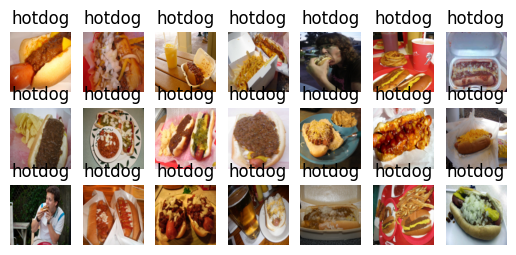

In [71]:
from utils import data_to_img_array
for data, labels in classifier.test_loader:
    images = data_to_img_array(data)
    for i in range(21):
        plt.subplot(5, 7, i+1)
        plt.imshow(images[i])
        plt.title(["hotdog", "not hotdog"][labels[i].item()])
        plt.axis('off')
    break

In [72]:
# Set your CAM extractor
cam_extractor = SmoothGradCAMpp(model, target_layer='convolutional') # layer 4 is the last conv layer of the model
# get your input
input_tensor = data[0].unsqueeze(0).to(device)

out = model(input_tensor)
# Retrieve the CAM by passing the class index and the model output
cams = cam_extractor(out.squeeze(0).argmax().item(), out)


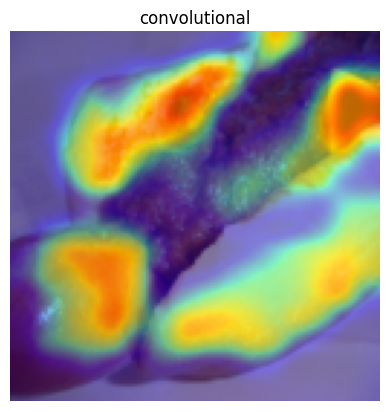

In [73]:
img = images[0]
for name, cam in zip(cam_extractor.target_names, cams):
  result = overlay_mask(to_pil_image(img), to_pil_image(cam.squeeze(0), mode='F'), alpha=0.5)
  plt.imshow(result); plt.axis('off'); plt.title(name); plt.show()
cam_extractor.remove_hooks()

IndexError: index 10 is out of bounds for axis 0 with size 10

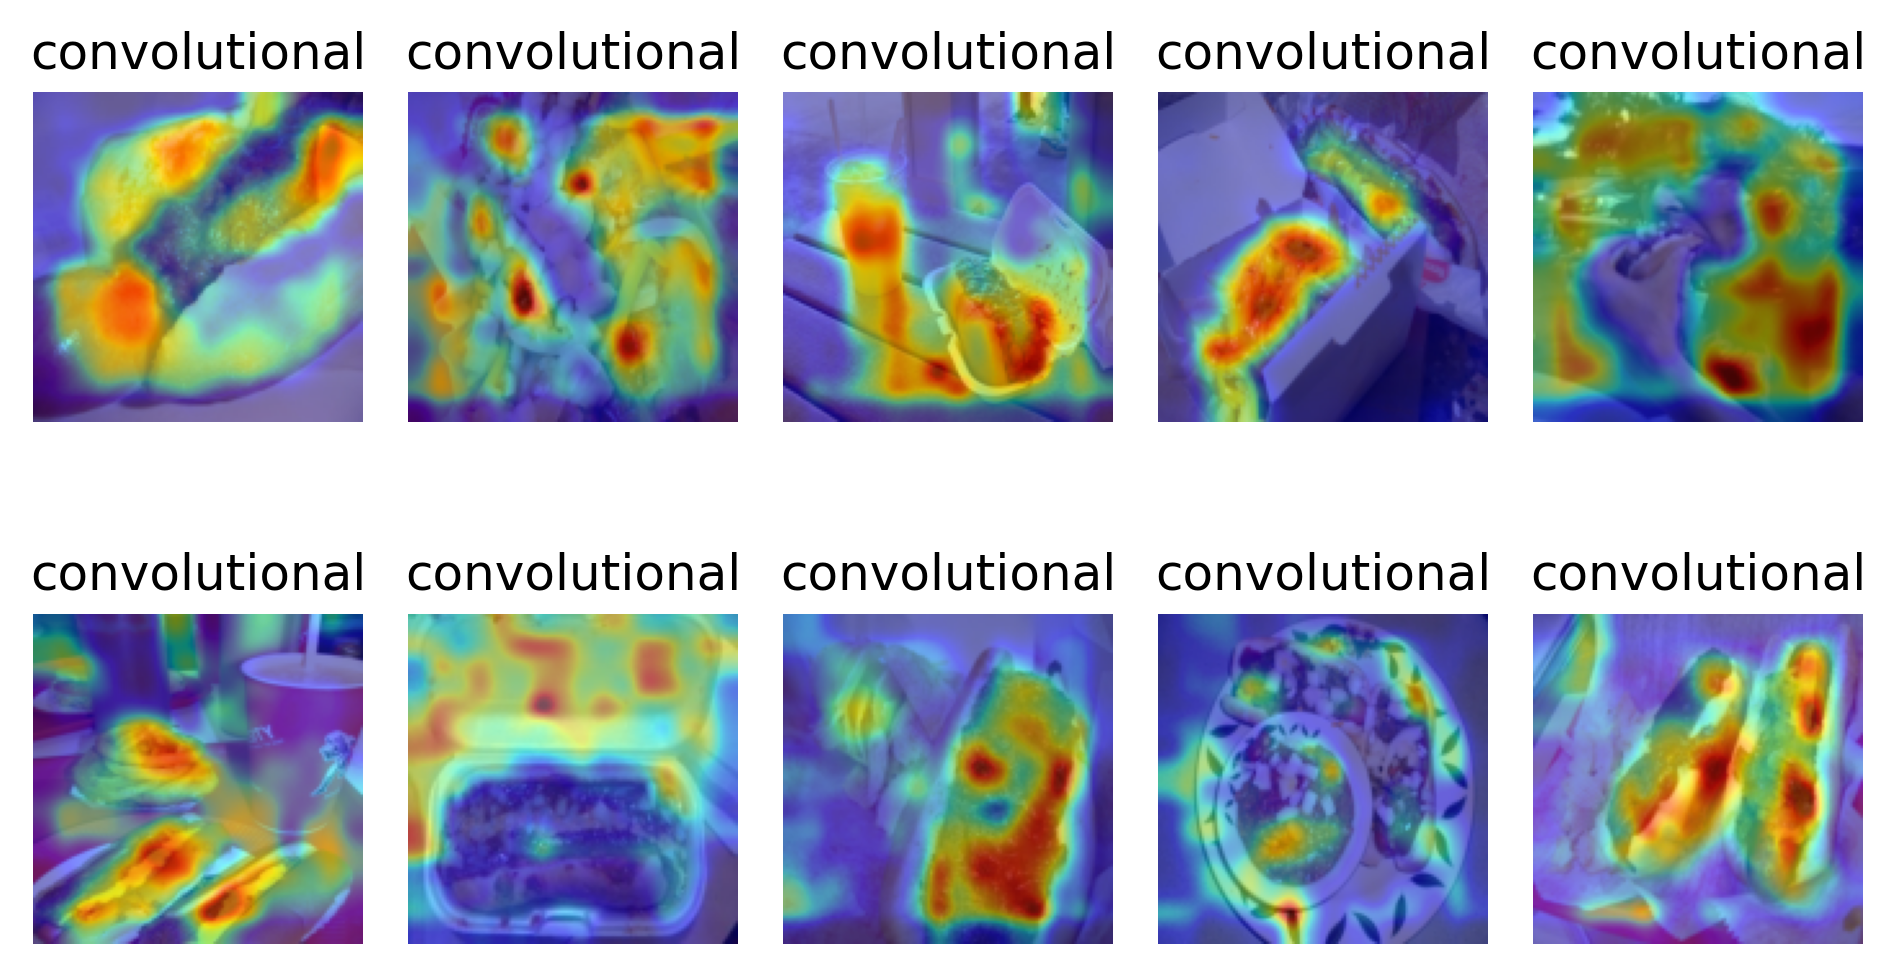

In [65]:
preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
cam_extractor = SmoothGradCAMpp(model, target_layer='convolutional')
fig, ax = plt.subplots(2,5, dpi=300, tight_layout=True)
ax = ax.ravel()
for i, img in enumerate(data):
    imgo = to_pil_image(img)
    #input_tensor = preprocess(imgo)
    input_tensor = img
    input_batch = input_tensor.unsqueeze(0).to(device)

    out = model(input_batch)
    cams = cam_extractor(out.squeeze(0).argmax().item(), out)

    for name, cam in zip(cam_extractor.target_names, cams):
        result = overlay_mask(imgo, to_pil_image(cam.squeeze(0), mode='F'), alpha=0.5)
        ax[i].imshow(result); ax[i].set_axis_off(); ax[i].set_title(name);
cam_extractor.remove_hooks()
     


TypeError: 'Axes' object is not subscriptable

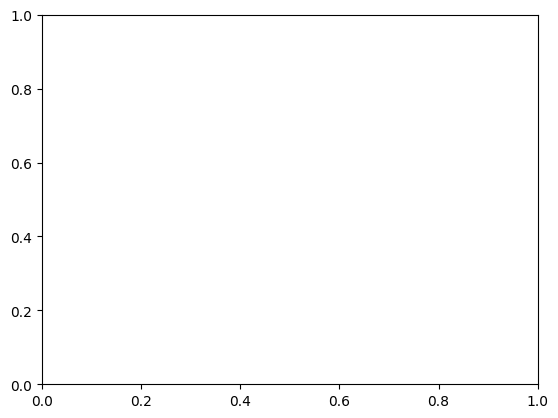

In [57]:

# Retrieve the CAM from several layers at the same time
model_layers = ['convolutional']
cam_extractor = LayerCAM(model, model_layers)

# Preprocess your data and feed it to the model
out = model(input_batch)
# Retrieve the CAM by passing the class index and the model output
cams = cam_extractor(out.squeeze(0).argmax().item(), out)
     


_, axes = plt.subplots(1, len(cam_extractor.target_names))
for idx, name, cam in zip(range(len(cam_extractor.target_names)), cam_extractor.target_names, cams):
  axes[idx].imshow(cam.squeeze(0).cpu().numpy()); axes[idx].axis('off'); axes[idx].set_title(name);
plt.show()
     
